### Advanced IK using `Panda`
- Basic numerical IK with a single target
- Augmented Jacobian Method for multiple targets
- Nullspace Control

In [1]:
import os,glfw
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mujoco_viewer
np.set_printoptions(precision=2,suppress=True,linewidth=100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.2]


### Util function

In [2]:
def rpy2r(rpy):
    """
        roll,pitch,yaw in radian to R
    """
    roll  = rpy[0]
    pitch = rpy[1]
    yaw   = rpy[2]
    Cphi  = np.math.cos(roll)
    Sphi  = np.math.sin(roll)
    Cthe  = np.math.cos(pitch)
    Sthe  = np.math.sin(pitch)
    Cpsi  = np.math.cos(yaw)
    Spsi  = np.math.sin(yaw)
    R     = np.array([
        [Cpsi * Cthe, -Spsi * Cphi + Cpsi * Sthe * Sphi, Spsi * Sphi + Cpsi * Sthe * Cphi],
        [Spsi * Cthe, Cpsi * Cphi + Spsi * Sthe * Sphi, -Cpsi * Sphi + Spsi * Sthe * Cphi],
        [-Sthe, Cthe * Sphi, Cthe * Cphi]
    ])
    assert R.shape == (3, 3)
    return R

def r2w(R):
    """
        R to \omega
    """
    el = np.array([
            [R[2,1] - R[1,2]],
            [R[0,2] - R[2,0]], 
            [R[1,0] - R[0,1]]
        ])
    norm_el = np.linalg.norm(el)
    if norm_el > 1e-10:
        w = np.arctan2(norm_el, np.trace(R)-1) / norm_el * el
    elif R[0,0] > 0 and R[1,1] > 0 and R[2,2] > 0:
        w = np.array([[0, 0, 0]]).T
    else:
        w = np.math.pi/2 * np.array([[R[0,0]+1], [R[1,1]+1], [R[2,2]+1]])
    return w.flatten()

def trim_scale(x,th):
    """
        Trim scale
    """
    x         = np.copy(x)
    x_abs_max = np.abs(x).max()
    if x_abs_max > th:
        x = x*th/x_abs_max
    return x

class MuJoCoParserClass(object):
    def __init__(self,name='Robot',rel_xml_path=None,USE_MUJOCO_VIEWER=False,VERBOSE=True):
        """
            Initialize MuJoCo parser
        """
        self.name         = name
        self.rel_xml_path = rel_xml_path
        self.VERBOSE      = VERBOSE
        # Constants
        self.tick          = 0
        # Parse an xml file
        if self.rel_xml_path is not None:
            self._parse_xml()
        # Viewer
        self.USE_MUJOCO_VIEWER = USE_MUJOCO_VIEWER
        if self.USE_MUJOCO_VIEWER:
            self.init_viewer()
        # Reset
        self.reset()
        # Print
        if self.VERBOSE:
            self.print_info()
        
    def _parse_xml(self):
        """
            Parse an xml file
        """
        self.full_xml_path   = os.path.abspath(os.path.join(os.getcwd(),self.rel_xml_path))
        self.model           = mujoco.MjModel.from_xml_path(self.full_xml_path)
        self.data            = mujoco.MjData(self.model)
        self.n_body          = self.model.nbody # number of bodies
        self.body_names      = [mujoco.mj_id2name(self.model,mujoco.mjtObj.mjOBJ_BODY,x) 
                                for x in range(self.n_body)]
        self.n_dof           = self.model.nv # degree of freedom
        self.n_joint         = self.model.njnt     # number of joints
        self.joint_names     = [mujoco.mj_id2name(self.model,mujoco.mjtJoint.mjJNT_HINGE,x) 
                                for x in range(self.n_joint)]
        self.joint_types     = self.model.jnt_type # joint types
        self.joint_ranges    = self.model.jnt_range # joint ranges
        self.rev_joint_idxs  = np.where(self.joint_types==mujoco.mjtJoint.mjJNT_HINGE)[0].astype(np.int32)
        self.rev_joint_names = [self.joint_names[x] for x in self.rev_joint_idxs]
        self.n_rev_joint     = len(self.rev_joint_idxs)
        self.rev_joint_min   = self.joint_ranges[self.rev_joint_idxs,0]
        self.rev_joint_max   = self.joint_ranges[self.rev_joint_idxs,1]
        self.rev_joint_range = self.rev_joint_max - self.rev_joint_min
        self.pri_joint_idxs  = np.where(self.joint_types==mujoco.mjtJoint.mjJNT_SLIDE)[0].astype(np.int32)
        self.pri_joint_names = [self.joint_names[x] for x in self.pri_joint_idxs]
        self.n_pri_joint     = len(self.pri_joint_idxs)
        
    def print_info(self):
        """
            Printout model information
        """
        print ("n_body:[%d]"%(self.n_body))
        print ("body_names:%s"%(self.body_names))
        print ("n_joint:[%d]"%(self.n_joint))
        print ("joint_names:%s"%(self.joint_names))
        print ("joint_types:%s"%(self.joint_types))
        print ("joint_ranges:\n%s"%(self.joint_ranges))
        print ("n_rev_joint:[%d]"%(self.n_rev_joint))
        print ("rev_joint_idxs:%s"%(self.rev_joint_idxs))
        print ("rev_joint_names:%s"%(self.rev_joint_names))
        print ("rev_joint_min:%s"%(self.rev_joint_min))
        print ("rev_joint_max:%s"%(self.rev_joint_max))
        print ("rev_joint_range:%s"%(self.rev_joint_range))
        print ("n_pri_joint:[%d]"%(self.n_pri_joint))
        print ("pri_joint_idxs:%s"%(self.pri_joint_idxs))
        print ("pri_joint_names:%s"%(self.pri_joint_names))
        
    def init_viewer(self,viewer_title='MuJoCo',viewer_width=1200,viewer_height=800,viewer_hide_menus=True):
        """
            Initialize viewer
        """
        self.USE_MUJOCO_VIEWER = True
        self.viewer = mujoco_viewer.MujocoViewer(
                self.model,self.data,mode='window',title=viewer_title,
                width=viewer_width,height=viewer_height,hide_menus=viewer_hide_menus)
        
    def update_viewer(self,azimuth=None,distance=None,elevation=None,lookat=None,
                      VIS_TRANSPARENT=None):
        """
            Initialize viewer
        """
        if azimuth is not None:
            self.viewer.cam.azimuth = azimuth
        if distance is not None:
            self.viewer.cam.distance = distance
        if elevation is not None:
            self.viewer.cam.elevation = elevation
        if lookat is not None:
            self.viewer.cam.lookat = lookat
        if VIS_TRANSPARENT is not None:
            self.viewer.vopt.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = VIS_TRANSPARENT
        mujoco.mj_forward(self.model,self.data)

    def is_viewer_alive(self):
        """
            Check whether a viewer is alive
        """
        return self.viewer.is_alive
        
    def reset(self):
        """
            Reset
        """
        mujoco.mj_resetData(self.model,self.data)
        mujoco.mj_forward(self.model,self.data)
        self.tick = 0
        
    def forward(self,q=None,joint_idxs=None):
        """
            Forward kinematics
        """
        if q is not None:
            if joint_idxs is not None:
                self.data.qpos[joint_idxs] = q
            else:
                self.data.qpos = q
        mujoco.mj_forward(self.model,self.data)
        self.tick = self.tick + 1
        
    def render(self):
        """
            Render
        """
        if self.USE_MUJOCO_VIEWER:
            self.viewer.render()
        else:
            print ("[%s] Viewer NOT initialized."%(self.name))
            
    def grab_image(self):
        """
            Grab the rendered iamge
        """
        img = np.zeros((self.viewer.viewport.height,self.viewer.viewport.width,3),dtype=np.uint8)
        mujoco.mjr_render(self.viewer.viewport,self.viewer.scn,self.viewer.ctx)
        mujoco.mjr_readPixels(img, None,self.viewer.viewport,self.viewer.ctx)
        img = np.flipud(img) # flip image
        return img
            
    def close_viewer(self):
        """
            Close viewer
        """
        self.USE_MUJOCO_VIEWER = False
        self.viewer.close()
        
    def get_p_body(self,body_name):
        """
            Get body position
        """
        return self.data.body(body_name).xpos
    
    def get_R_body(self,body_name):
        """
            Get body rotation matrix
        """
        return self.data.body(body_name).xmat.reshape([3,3])
    
    def get_pR_body(self,body_name):
        """
            Get body position and rotation matrix
        """
        p = self.get_p_body(body_name)
        R = self.get_R_body(body_name)
        return p,R
    
    def get_q(self,joint_idxs=None):
        """
            Get joint position in (radian)
        """
        if joint_idxs is None:
            q = self.data.qpos
        else:
            q = self.data.qpos[joint_idxs]
        return q
        
    def get_J_body(self,body_name):
        """
            Get Jocobian matrices of a body
        """
        J_p = np.zeros((3,self.model.nv)) # nv: nDoF
        J_R = np.zeros((3,self.model.nv))
        mujoco.mj_jacBody(self.model,self.data,J_p,J_R,self.data.body(body_name).id)
        J_full = np.array(np.vstack([J_p,J_R]))
        return J_p,J_R,J_full
    
    def get_ik_ingredients(self,body_name,p_trgt=None,R_trgt=None,IK_P=True,IK_R=True):
        """
            Get IK ingredients
        """
        J_p,J_R,J_full = self.get_J_body(body_name=body_name)
        p_curr,R_curr = self.get_pR_body(body_name=body_name)
        if (IK_P and IK_R):
            p_err = (p_trgt-p_curr)
            R_err = np.linalg.solve(R_curr,R_trgt)
            w_err = R_curr @ r2w(R_err)
            J     = J_full
            err   = np.concatenate((p_err,w_err))
        elif (IK_P and not IK_R):
            p_err = (p_trgt-p_curr)
            J     = J_p
            err   = p_err
        elif (not IK_P and IK_R):
            R_err = np.linalg.solve(R_curr,R_trgt)
            w_err = R_curr @ r2w(R_err)
            J     = J_R
            err   = w_err
        else:
            J   = None
            err = None
        return J,err

    def damped_ls(self,J,err,eps=1e-6,stepsize=1.0,th=5*np.pi/180.0):
        """
            Dampled least square for IK
        """
        dq = stepsize*np.linalg.solve(a=(J.T@J)+eps*np.eye(J.shape[1]),b=J.T@err)
        dq = trim_scale(x=dq,th=th)
        return dq
    
    def plot_sphere(self,p,r,rgba,label=''):
        """
            Add sphere
        """
        self.viewer.add_marker(
            pos   = pos,
            size  = [r,r,r],
            rgba  = rgba,
            type  = mujoco.mjtGeom.mjGEOM_SPHERE,
            label = label)
        
    def plot_T(self,p,R,
               PLOT_AXIS=True,axis_len=1.0,axis_width=0.01,
               PLOT_SPHERE=False,sphere_r=0.05,sphere_rgba=[1,0,0,0.5],
               label=None):
        """
            Plot coordinate axes
        """
        if PLOT_AXIS:
            rgba_x = [1.0,0.0,0.0,0.9]
            rgba_y = [0.0,1.0,0.0,0.9]
            rgba_z = [0.0,0.0,1.0,0.9]
            # X axis
            R_x = R@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([1,0,0]))
            p_x = p + R_x[:,2]*axis_len/2
            self.viewer.add_marker(
                pos   = p_x,
                type  = mujoco.mjtGeom.mjGEOM_CYLINDER,
                size  = [axis_width,axis_width,axis_len/2],
                mat   = R_x,
                rgba  = rgba_x,
                label = ''
            )
            R_y = R@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([0,1,0]))
            p_y = p + R_y[:,2]*axis_len/2
            self.viewer.add_marker(
                pos   = p_y,
                type  = mujoco.mjtGeom.mjGEOM_CYLINDER,
                size  = [axis_width,axis_width,axis_len/2],
                mat   = R_y,
                rgba  = rgba_y,
                label = ''
            )
            R_z = R@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([0,0,1]))
            p_z = p + R_z[:,2]*axis_len/2
            self.viewer.add_marker(
                pos   = p_z,
                type  = mujoco.mjtGeom.mjGEOM_CYLINDER,
                size  = [axis_width,axis_width,axis_len/2],
                mat   = R_z,
                rgba  = rgba_z,
                label = ''
            )
        if PLOT_SPHERE:
            self.viewer.add_marker(
                pos   = p,
                size  = [sphere_r,sphere_r,sphere_r],
                rgba  = sphere_rgba,
                type  = mujoco.mjtGeom.mjGEOM_SPHERE,
                label = '')
        if label is not None:
            self.viewer.add_marker(
                pos   = p,
                size  = [0.0001,0.0001,0.0001],
                rgba  = [1,1,1,0.01],
                type  = mujoco.mjtGeom.mjGEOM_SPHERE,
                label = label)

print ("Ready.")

Ready.


### Parse `Panda`

In [3]:
xml_path = '../model/panda/franka_panda.xml'
env = MuJoCoParserClass(name='Panda',rel_xml_path=xml_path,VERBOSE=False)
print ("[Panda] parsed.")

[Panda] parsed.


### IK with multiple targets using `Augmented Jacobian Method`

In [ ]:
env.init_viewer(viewer_title='IK using Panda',viewer_width=1200,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=80,distance=2.5,elevation=-30,lookat=[0,0,1.5])
env.update_viewer(VIS_TRANSPARENT=True) # transparent
env.reset() # reset
# Set (multiple) IK targets
ik_body_names = ['panda_eef','panda_link_4']
ik_p_trgts = [env.get_p_body(body_name='panda_eef')+np.array([0.5,0.0,-0.5]),
              env.get_p_body(body_name='panda_link_4')+np.array([0.0,0.0,0.0])]
ik_R_trgts = [env.get_R_body(body_name='panda_eef')@rpy2r(0.0*np.random.randn(3)*np.pi/180.0),
              env.get_R_body(body_name='panda_link_4')@rpy2r(0.0*np.random.randn(3)*np.pi/180.0)]
IK_Ps = [True,True]
IK_Rs = [True,False]
# Loop
q = env.get_q(joint_idxs=env.rev_joint_idxs)
imgs,img_ticks,max_tick = [],[],1000
while (env.tick < max_tick) and env.is_viewer_alive():
    # Numerical IK
    J_aug,err_aug = [],[]
    for ik_idx,ik_body_name in enumerate(ik_body_names):
        p_trgt,R_trgt = ik_p_trgts[ik_idx],ik_R_trgts[ik_idx]
        IK_P,IK_R = IK_Ps[ik_idx],IK_Rs[ik_idx]
        J,err = env.get_ik_ingredients(
            body_name=ik_body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=IK_P,IK_R=IK_R)
        if (J is None) and (err is None): continue
        if len(J_aug) == 0:
            J_aug,err_aug = J,err
        else:
            J_aug   = np.concatenate((J_aug,J),axis=0)
            err_aug = np.concatenate((err_aug,err),axis=0)
    dq = env.damped_ls(J_aug,err_aug,stepsize=1,eps=1e-1,th=5*np.pi/180.0)
    # Update q and FK
    q = q + dq[env.rev_joint_idxs]
    env.forward(q=q,joint_idxs=env.rev_joint_idxs)
    # Render
    for ik_idx,ik_body_name in enumerate(ik_body_names):
        p_trgt,R_trgt = ik_p_trgts[ik_idx],ik_R_trgts[ik_idx]
        IK_P,IK_R = IK_Ps[ik_idx],IK_Rs[ik_idx]
        if (IK_P is None) and (IK_R is None): continue
        env.plot_T(p=env.get_p_body(body_name=ik_body_name),R=env.get_R_body(body_name=ik_body_name),
                   PLOT_AXIS=IK_R,axis_len=0.2,axis_width=0.01,
                   PLOT_SPHERE=IK_P,sphere_r=0.05,sphere_rgba=[1,0,0,0.9])
        env.plot_T(p=p_trgt,R=R_trgt,
                   PLOT_AXIS=IK_R,axis_len=0.2,axis_width=0.01,
                   PLOT_SPHERE=IK_P,sphere_r=0.05,sphere_rgba=[0,0,1,0.9])
    env.plot_T(p=[0,0,0],R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0)
    env.render()
    # Print and save image 
    if (env.tick)%(max_tick//10)==0 or (env.tick==1):
        print ("[%d/%d] IK error:[%.4f]"%(env.tick,max_tick,np.linalg.norm(err_aug)))
        img = env.grab_image()
        imgs.append(img)
        img_ticks.append(env.tick)
# Close viewer
env.close_viewer()
print ("Done.")

In [ ]:
# Plot snapshots for Panda solving IK
fig = plt.figure(figsize=(10,5))
for i_idx,img in enumerate(imgs):
    ax = fig.add_subplot(3,4,i_idx+1)
    ax.imshow(img)
    ax.set_title('[%d] tick:[%d]'%(i_idx,img_ticks[i_idx]),fontsize=8)
    ax.axis('off')

### Nullspace projected IK with task space target

In [8]:
env.init_viewer(viewer_title='IK using Panda',viewer_width=1200,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=80,distance=2.5,elevation=-30,lookat=[0,0,1.5])
env.update_viewer(VIS_TRANSPARENT=True) # transparent
env.reset() # reset
# Set the primary and the secondary IK targets
ik_body_name_pri = 'panda_eef'
ik_body_name_sec = 'panda_link_4'
p_trgt_pri = env.get_p_body(body_name='panda_eef')+np.array([0.5,0.0,-0.5])
p_trgt_sec = env.get_p_body(body_name='panda_link_4')+np.array([0,0,0])
# Loop
q = env.get_q(joint_idxs=env.rev_joint_idxs)
imgs,img_ticks,max_tick = [],[],200
while (env.tick < max_tick) and env.is_viewer_alive():
    # Get IK ingredients for the primary target
    J_pri,err_pri = env.get_ik_ingredients(
        body_name=ik_body_name_pri,p_trgt=p_trgt_pri,R_trgt=None,IK_P=True,IK_R=False)
    dq_pri = env.damped_ls(J_pri,err_pri,stepsize=1,eps=1e-1,th=5*np.pi/180.0)
    # Get IK ingredients for the nullspace
    J_sec,err_sec = env.get_ik_ingredients(
        body_name=ik_body_name_sec,p_trgt=p_trgt_sec,R_trgt=None,IK_P=True,IK_R=False)
    dq_sec = env.damped_ls(J_sec,err_sec,stepsize=1,eps=1e-1,th=5*np.pi/180.0)
    # Combine the primary with the secondary with nullspace projection
    dq = dq_pri + (np.eye(env.n_dof,env.n_dof)-np.linalg.pinv(J_pri)@J_pri)@dq_sec;
    # Update q and FK
    q = q + dq[env.rev_joint_idxs]
    env.forward(q=q,joint_idxs=env.rev_joint_idxs)
    # Render
    env.plot_T(p=env.get_p_body(body_name=ik_body_name_pri),R=None,
               PLOT_AXIS=False,PLOT_SPHERE=True,sphere_r=0.05,sphere_rgba=[1,0,0,0.9])
    env.plot_T(p=p_trgt_pri,R=None,
               PLOT_AXIS=False,PLOT_SPHERE=True,sphere_r=0.05,sphere_rgba=[0,0,1,0.9])
    env.plot_T(p=env.get_p_body(body_name=ik_body_name_sec),R=None,
               PLOT_AXIS=False,PLOT_SPHERE=True,sphere_r=0.05,sphere_rgba=[1,0,0,0.9])
    env.plot_T(p=p_trgt_sec,R=None,
               PLOT_AXIS=False,PLOT_SPHERE=True,sphere_r=0.05,sphere_rgba=[0,0,1,0.9])
    env.plot_T(p=[0,0,0],R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0)
    env.render()
    # Print and save image 
    if (env.tick)%(max_tick//10)==0 or (env.tick==1):
        print ("[%d/%d] IK error primary:[%.4f] secondary:[%.4f]"%
               (env.tick,max_tick,np.linalg.norm(err_pri),np.linalg.norm(err_sec)))
        img = env.grab_image()
        imgs.append(img)
        img_ticks.append(env.tick)
# Close viewer
env.close_viewer()
print ("Done.")

[1/200] IK error primary:[0.7071] secondary:[0.0000]
[20/200] IK error primary:[0.0078] secondary:[0.2930]
[40/200] IK error primary:[0.0001] secondary:[0.1913]
[60/200] IK error primary:[0.0001] secondary:[0.1007]
[80/200] IK error primary:[0.0000] secondary:[0.0385]
[100/200] IK error primary:[0.0000] secondary:[0.0176]
[120/200] IK error primary:[0.0000] secondary:[0.0097]
[140/200] IK error primary:[0.0000] secondary:[0.0059]
[160/200] IK error primary:[0.0000] secondary:[0.0037]
[180/200] IK error primary:[0.0000] secondary:[0.0024]
[200/200] IK error primary:[0.0000] secondary:[0.0016]
Done.


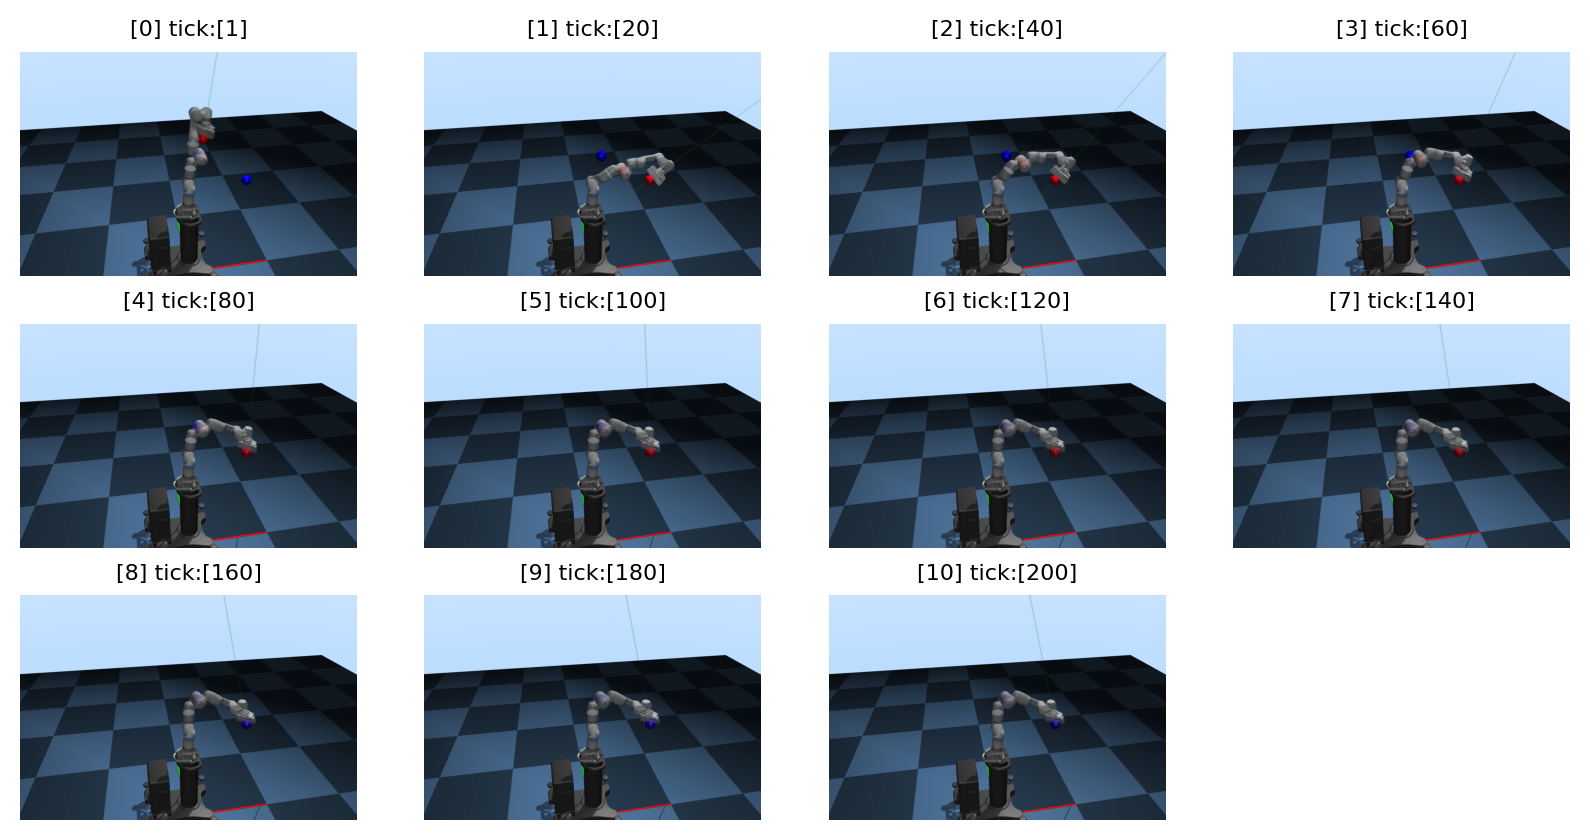

In [9]:
# Plot snapshots for Panda solving IK
fig = plt.figure(figsize=(10,5))
for i_idx,img in enumerate(imgs):
    ax = fig.add_subplot(3,4,i_idx+1)
    ax.imshow(img)
    ax.set_title('[%d] tick:[%d]'%(i_idx,img_ticks[i_idx]),fontsize=8)
    ax.axis('off')